# Comparison of Qiskit SABRE vs Qibo SABRE

- 10-qubit QFT
- line graph vs cycle graph
- the number of CNOTs
- Qibo vs Qiskit

### Utils

#### `qibo.cskim_utils.connectivity.line_connectivity_`

```py
def line_connectivity_nx(n):
    """
    Returns a line graph with n nodes and n-1 edges.
    Return nx.Graph.
    For Qibo.
    """


def line_connectivity_cmap(n):
    """
    Returns a line graph with n nodes and n-1 edges.
    Return list of lists (Coupling map).
    For Qiskit.
    """

```

#### `qibo.cskim_utils.connectivity.cycle_connectivity_`


```py
def cycle_connectivity_nx(n):
    """
    Returns a cycle graph with n nodes and n edges.
    Return nx.Graph.
    For Qibo.
    """

def cycle_connectivity_cmap(n):
    """
    Returns a cycle graph with n nodes and n edges.
    Return list of lists (Coupling map).
    For Qiskit.
    """
```

#### `qibo.cskim_utils.gen_circuit.qiskit_qft`

```py
def qiskit_qft(n):
    """
    Returns a Qiskit QuantumCircuit object for the QFT on n qubits.
    """
```


#### `qibo.cskim_utils.circuit_info.count_czs_qiskit`

```py
def count_czs_qiskit(circuit):
    """
    Count the number of CZ gates in a Qiskit circuit.
    """
    ```

#### `qibo.cskim_utils.gen_circuit.gen_transpiled_circuits_qibo`

```py
def gen_transpiled_circuits_qibo(circuit, conn, placer, router):
    """
    Transpile a Qibo circuit using the given connectivity, placer, and router.
    Optimiser and unroller are set to default.
    """
```

## Qibo Transpilation

- QFT(3)

In [42]:
from qibo.models import QFT
from qibo.cskim_utils.connectivity import line_connectivity_nx
from qibo.transpiler.placer import ReverseTraversal
from qibo.transpiler.router import Sabre

from qibo.cskim_utils.gen_circuit import gen_transpiled_circuits_qibo
from qibo.cskim_utils.circuit_info import count_czs_qibo
from qibo.cskim_utils.connectivity import cycle_connectivity_nx



In [9]:
nqubits = 3

In [10]:
# qibo.models.QFT
qft_circ_qibo = QFT(nqubits)

print(qft_circ_qibo.draw(line_wrap=1000))

q0: ─H─U1─U1────────x─
q1: ───o──|──H─U1───|─
q2: ──────o────o──H─x─


In [17]:
# Line connectivity
conn = line_connectivity_nx(nqubits)

# Placer and Router
router_sabre = Sabre(connectivity=conn)
placer = ReverseTraversal(connectivity=conn, routing_algorithm=router_sabre)
# placer = Random(connectivity=conn)
# placer = Subgraph(connectivity=conn)
# placer = Trivial(connectivity=conn)

# Transpile
transpiled_circ = gen_transpiled_circuits_qibo(qft_circ_qibo, conn, placer, router_sabre)
print(transpiled_circ.draw(line_wrap=1000))
print("#czs after_transpiling", count_czs_qibo(transpiled_circ))

q0: ─Z──GPI2─Z─GPI2─Z─Z─GPI2─RZ─GPI2─Z─Z─GPI2─RZ─────────────────────Z──GPI2─Z─Z─GPI2─RZ─GPI2─Z─Z──GPI2─RZ───────────────────────────────────o─Z─GPI2─Z─Z─GPI2─o────────
q1: ─RZ─────────────o────────────────o─Z─GPI2────o─Z─GPI2─Z─Z─GPI2─o─RZ──────o────────────────o─RZ─────────o────────────────o─Z─GPI2─Z──GPI2─Z─Z─GPI2─o─Z─GPI2─Z─Z─GPI2─
q2: ───────────────────────────────────Z─GPI2────Z─Z─GPI2─o─Z─GPI2─Z─Z──GPI2────────────────────Z──GPI2────Z─Z─GPI2─RZ─GPI2─Z─Z─GPI2─RZ─────────────────────────────────
#czs after_transpiling 12


## Qiskit Transpilation

- QFT(3)

In [41]:
from qiskit import transpile

from qibo.cskim_utils.circuit_info import count_czs_qiskit
from qibo.cskim_utils.connectivity import line_connectivity_cmap
from qibo.cskim_utils.gen_circuit import qiskit_qft
from qibo.cskim_utils.connectivity import cycle_connectivity_cmap

In [18]:
# Qiskit QFT circuit
qft_circ_qiskit = qiskit_qft(nqubits)
display(qft_circ_qiskit.draw(fold=-1))

┌───┐                                        
q_0: ┤ H ├─■────────■───────────────────────────X─
     └───┘ │        │P(π/2) ┌───┐               │ 
q_1: ──────┼────────■───────┤ H ├─■─────────────┼─
           │P(π/4)          └───┘ │P(π/2) ┌───┐ │ 
q_2: ──────■──────────────────────■───────┤ H ├─X─
                                          └───┘

In [19]:
# Line coupling map
cmap = line_connectivity_cmap(nqubits)

qc_basis = transpile(qft_circ_qiskit, coupling_map=cmap, basis_gates=['cz', 'u3'], optimization_level=3)
display(qc_basis.draw(fold=-1))

print("#czs after_transpiling", count_czs_qiskit(qc_basis))

global phase: 3π/4
         ┌──────────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                                 ┌──────────────────┐    ┌────────────────┐                      
q_0 -> 0 ┤ U3(0,1.4066,-1.4066) ├─■─┤ U3(π/8,π/2,-π/2) ├─■─┤ U3(π/8,-π/2,π/2) ├───────────────────────────────────────────────■─┤ U3(π/4,π/2,-π/2) ├─■──┤ U3(π/2,π/4,-π) ├──────────────────────
         └───┬─────────────┬────┘ │ └──────────────────┘ │ ├──────────────────┤   ┌──────────────────┐   ┌──────────────────┐ │ └──────────────────┘ │ ┌┴────────────────┴┐   ┌────────────────┐
q_2 -> 1 ────┤ U3(0,0,π/8) ├──────■──────────────────────■─┤ U3(π/2,-π/2,π/2) ├─■─┤ U3(π/2,-π/2,π/2) ├─■─┤ U3(π/2,-π/4,π/2) ├─■──────────────────────■─┤ U3(π/4,π/2,-π/2) ├─■─┤ U3(π/2,π/4,-π) ├
           ┌─┴─────────────┴──┐                            └──────────────────┘ │ ├──────────────────┤ │ ├──────────────────┤                          └──────────────────┘ │ └┬─────────────┬─┘
q_1 -> 2 ──┤ U3(π/2,-π/2,π/2) ├─────────────────────────────────────────────────■─┤ U3(π/2,-π/2,π/2) ├─■─┤ U3(π/2,-π/4,π/2) ├───────────────────────────────────────────────■──┤ U3(π/2,0,π) ├──
           └──────────────────┘                                                   └──────────────────┘   └──────────────────┘                                                  └─────────────┘

#czs after_transpiling 7


## Comparison 1

- line connectivity
- QFT(10)
- `repeat`: 50

In [34]:
ncz_qibo_line = []
ncz_qiskit_line = []
repeat = 50

# Qibo QFT circuit
nqubits = 10
qft_circ_qibo = QFT(nqubits)

# Line connectivity
conn = line_connectivity_nx(nqubits)
cmap = line_connectivity_cmap(nqubits)

# Qibo Placer and Router
router_sabre = Sabre(connectivity=conn)
placer = ReverseTraversal(connectivity=conn, routing_algorithm=router_sabre)

# Qiskit QFT circuit
qft_circ_qiskit = qiskit_qft(nqubits)

for i in range(repeat):
    # Qibo Transpilation
    transpiled_circ = gen_transpiled_circuits_qibo(qft_circ_qibo, conn, placer, router_sabre)
    czs_qb = count_czs_qibo(transpiled_circ)
    ncz_qibo_line.append(czs_qb)

    # Qiskit Transpilation
    qc_basis = transpile(qft_circ_qiskit, coupling_map=cmap, basis_gates=['cz', 'u3'], optimization_level=3)
    czs_qsk = count_czs_qiskit(qc_basis)
    ncz_qiskit_line.append(czs_qsk)

print("Avg #CZs, line connectivity, Qibo:", sum(ncz_qibo_line)/repeat)
print("Avg #CZs, line connectivity, Qiskit:", sum(ncz_qiskit_line)/repeat)
print()
print("Min #CZs, line connectivity, Qibo:", min(ncz_qibo_line))
print("Min #CZs, line connectivity, Qiskit:", min(ncz_qiskit_line))

Avg #CZs, line connectivity, Qibo: 280.92
Avg #CZs, line connectivity, Qiskit: 280.1

Min #CZs, line connectivity, Qibo: 276
Min #CZs, line connectivity, Qiskit: 270


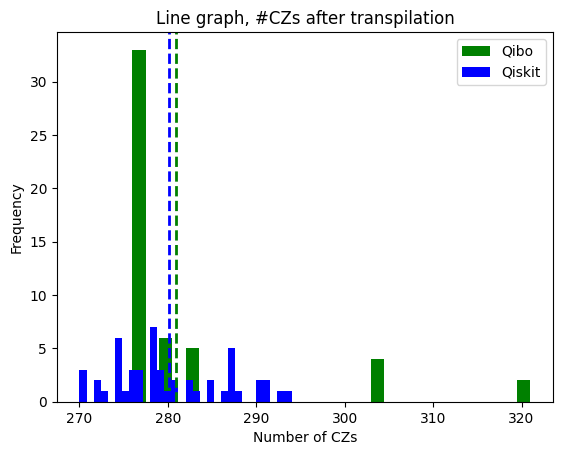

In [38]:
import matplotlib.pyplot as plt

plt.hist(ncz_qibo_line, bins=30, color='g', label='Qibo')
plt.hist(ncz_qiskit_line, bins=30, color='b', label='Qiskit')
plt.axvline(sum(ncz_qibo_line)/repeat, color='g', linestyle='dashed', linewidth=2)
plt.axvline(sum(ncz_qiskit_line)/repeat, color='b', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel("Number of CZs")
plt.ylabel("Frequency")
plt.title("Line graph, #CZs after transpilation")
plt.show()

## Comparison 2

- cycle connectivity
- QFT(10)
- `repeat`: 50

In [43]:
ncz_qibo_line = []
ncz_qiskit_line = []
repeat = 50

# Qibo QFT circuit
nqubits = 10
qft_circ_qibo = QFT(nqubits)

# Line connectivity
conn = cycle_connectivity_nx(nqubits)
cmap = cycle_connectivity_cmap(nqubits)

# Qibo Placer and Router
router_sabre = Sabre(connectivity=conn)
placer = ReverseTraversal(connectivity=conn, routing_algorithm=router_sabre)

# Qiskit QFT circuit
qft_circ_qiskit = qiskit_qft(nqubits)

for i in range(repeat):
    # Qibo Transpilation
    transpiled_circ = gen_transpiled_circuits_qibo(qft_circ_qibo, conn, placer, router_sabre)
    czs_qb = count_czs_qibo(transpiled_circ)
    ncz_qibo_line.append(czs_qb)

    # Qiskit Transpilation
    qc_basis = transpile(qft_circ_qiskit, coupling_map=cmap, basis_gates=['cz', 'u3'], optimization_level=3)
    czs_qsk = count_czs_qiskit(qc_basis)
    ncz_qiskit_line.append(czs_qsk)

print("Avg #CZs, line connectivity, Qibo:", sum(ncz_qibo_line)/repeat)
print("Avg #CZs, line connectivity, Qiskit:", sum(ncz_qiskit_line)/repeat)
print()
print("Min #CZs, line connectivity, Qibo:", min(ncz_qibo_line))
print("Min #CZs, line connectivity, Qiskit:", min(ncz_qiskit_line))

Avg #CZs, line connectivity, Qibo: 247.98
Avg #CZs, line connectivity, Qiskit: 244.42

Min #CZs, line connectivity, Qibo: 240
Min #CZs, line connectivity, Qiskit: 225


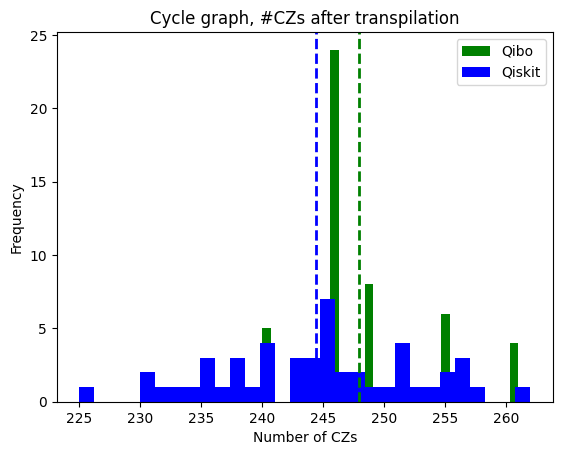

In [45]:
import matplotlib.pyplot as plt

plt.hist(ncz_qibo_line, bins=30, color='g', label='Qibo')
plt.hist(ncz_qiskit_line, bins=30, color='b', label='Qiskit')
plt.axvline(sum(ncz_qibo_line)/repeat, color='g', linestyle='dashed', linewidth=2)
plt.axvline(sum(ncz_qiskit_line)/repeat, color='b', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel("Number of CZs")
plt.ylabel("Frequency")
plt.title("Cycle graph, #CZs after transpilation")
plt.show()